## Setting up the travel time and transfer computations

In [1]:
import sys
sys.path.append("../")

from matplotlib import pyplot as plt
from matplotlib import rc

import example_import
from gtfspy.routing.helpers import get_transit_connections, get_walk_network
from gtfspy.routing.multi_objective_pseudo_connection_scan_profiler import MultiObjectivePseudoCSAProfiler
from gtfspy.routing.node_profile_analyzer_time_and_veh_legs import NodeProfileAnalyzerTimeAndVehLegs

G = example_import.load_or_import_example_gtfs()

from_stop_name = "Ahkiotie 2 E"
to_stop_name = "Kauppahalli P"
from_stop_I = None
to_stop_I = None
stop_dict = G.stops().to_dict("index")
for stop_I, data in stop_dict.items():
    if data['name'] == from_stop_name:
        from_stop_I = stop_I
    if data['name'] == to_stop_name:
        to_stop_I = stop_I
assert (from_stop_I is not None)
assert (to_stop_I is not None)

print("stop_Is of the departure and arrival stops: ", from_stop_I, to_stop_I)

# The start and end times between which PT operations (and footpaths) are scanned:
ANALYSIS_START_TIME_UT = G.get_suitable_date_for_daily_extract(ut=True) + 10 * 3600
# Analyze tremporal distances / travel times for one hour departure time interval:
ANALYSIS_END_TIME_UT = ANALYSIS_START_TIME_UT + 1 * 3600
# Normally scanning of PT connections (i.e. "routing") should start at the same time of the analysis start time:
CONNECTION_SCAN_START_TIME_UT = ANALYSIS_START_TIME_UT
# Consider only journey alternatives that arrive to the destination at most two hours
# later than last departure time of interest:
CONNECTION_SCAN_END_TIME_UT = ANALYSIS_END_TIME_UT + 2 * 3600

connections = get_transit_connections(G, CONNECTION_SCAN_START_TIME_UT, CONNECTION_SCAN_END_TIME_UT)
MAX_WALK_LENGTH = 1000
# Get the walking network with all stop-pairs that are less than 1000 meters apart.
walk_network = get_walk_network(G, MAX_WALK_LENGTH)

# Note that if you would want enable longer walking distances, e.g. 2000 meters, 
# then you may need to recompute the footpath lengths between stops with 
# gtfspy.osm_transfers.add_walk_distances_to_db_python(..., cutoff_distance_m=2000).


stop_Is of the departure and arrival stops:  162 3


## Computation of Pareto-optimal journey alternatives

In [2]:

mpCSA = MultiObjectivePseudoCSAProfiler(connections,
                                        targets=[to_stop_I],
                                        start_time_ut=CONNECTION_SCAN_START_TIME_UT,
                                        end_time_ut=CONNECTION_SCAN_END_TIME_UT,
                                        transfer_margin=120,  # seconds
                                        walk_network=walk_network,
                                        walk_speed=1.5,  # meters per second
                                        verbose=True,
                                        track_vehicle_legs=True,
                                        track_time=True)

mpCSA.run()

using label: <class 'gtfspy.routing.label.LabelTimeWithBoardingsCount'>
timeit: '__compute_stop_dep_and_arrival_times' 0.01 sec 
Started computing pseudoconnections
Computed pseudoconnections
timeit: '__compute_pseudo_connections' 0.33 sec 
timeit: '_add_pseudo_connection_departures_to_stop_departure_times' 0.04 sec 
timeit: '_augment_all_connections_with_arrival_stop_next_dep_time' 0.33 sec 
timeit: '__initialize_node_profiles' 0.03 sec 
 44000 / 44739  :  0.98finalizing profiles!
timeit: '_run' 1.89 sec 
timeit: 'run' 1.89 sec ('(<gtfspy.routing.mul', {}) 


## Computing travel time statistics based on the Pareto-optimal journey alternatives

In [3]:
profiles = mpCSA.stop_profiles

# Set up the analyzer for one origin-destination pair:
departure_stop_profile = profiles[from_stop_I]
direct_walk_duration = departure_stop_profile.get_walk_to_target_duration()
# This equals inf, if walking distance between the departure_stop (from_stop_I) and target_stop (to_stop_I)
# is longer than MAX_WALK_LENGTH
analyzer = NodeProfileAnalyzerTimeAndVehLegs(departure_stop_profile.get_final_optimal_labels(),
                                             direct_walk_duration,
                                             ANALYSIS_START_TIME_UT,
                                             ANALYSIS_END_TIME_UT)

# Print out results:
print("Origin:\n", stop_dict[from_stop_I])
print("Destination:\n", stop_dict[to_stop_I])
print("\nResults\n-------")
print("Minimum temporal distance: %.2f minutes" % (analyzer.min_temporal_distance() / 60.))
print("Mean temporal distance: %.2f minutes" % (analyzer.mean_temporal_distance() / 60.))
print("Median temporal distance: %.2f minutes" % (analyzer.median_temporal_distance() / 60.))
print("Maximum temporal distance: %.2f minutes" % (analyzer.max_temporal_distance() / 60.))
# Note that the mean and max temporal distances have the value of `direct_walk_duration`,
# if there are no journey alternatives departing after (or at the same time as) `ANALYSIS_END_TIME_UT`.
# Thus, if you obtain a float('inf') value for some of the temporal distance measures, it could probably be
# avoided by increasing the value of PT_CONNECTIONS_SCANNING_END_TIME_UT (while taking care that
# The median temporal distance is often more robust to this kind of service level variations.


Origin:
 {'code': None, 'lon': 27.642538, 'desc': None, 'location_type': None, 'self_or_parent_I': 163, 'parent_I': None, 'wheelchair_boarding': None, 'stop_I': 163, 'lat': 62.907265, 'stop_id': '201259', 'name': 'Ahkiotie 2 E'}
Destination:
 {'code': None, 'lon': 27.677356, 'desc': None, 'location_type': None, 'self_or_parent_I': 4, 'parent_I': None, 'wheelchair_boarding': None, 'stop_I': 4, 'lat': 62.891996, 'stop_id': '303022', 'name': 'Kauppahalli P'}

Results
-------
Minimum temporal distance: 16.42 minutes
Mean temporal distance: 27.58 minutes
Median temporal distance: 27.27 minutes
Maximum temporal distance: 39.35 minutes


## Plotting temporal distance (~travel time) profile between an OD-pair

Plotting...
Showing...


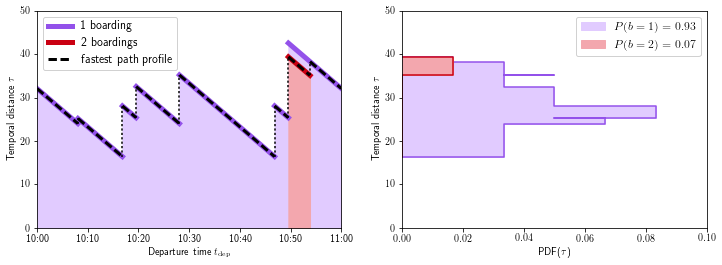

In [5]:
timezone_pytz = G.get_timezone_pytz()
print("Plotting...")

# use tex in plotting
rc("text", usetex=True)
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1 = analyzer.plot_new_transfer_temporal_distance_profile(timezone=timezone_pytz,
                                                            format_string="%H:%M", ax=ax1)
ax2 = analyzer.plot_temporal_distance_pdf_horizontal(use_minutes=True, ax=ax2)
ax2.set_xlabel("")
ax1.set_ylim(0,50)
ax2.set_ylim(0,50)
ax2.set_xlim(0,0.1)
ax2.set_xlabel(r"PDF($\tau$)")
ax2.set_ylabel(r"Temporal distance $\tau$")
print("Showing...")
plt.show()